<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº9
#### Federico Borello

# Filtrado Digital

Se sigue la [guía de laboratorio](https://nbviewer.org/github/marianux/jupytest/blob/master/Laboratorio%20de%20filtrado%20digital.ipynb) propuesta por la cátedra.

# Seteo las Señales

In [78]:
# Audio, ECG, PPG y Código original de la cátedra:
# https://nbviewer.org/github/marianux/jupytest/blob/master/Laboratorio%20de%20filtrado%20digital.ipynb

import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100  # dpi

fig_font_size = 16

mpl.rcParams["figure.figsize"] = (fig_sz_x, fig_sz_y)
plt.rcParams.update({"font.size": fig_font_size})
mat_struct = sio.loadmat("../TS8/ECG_TP4.mat")

ecg_one_lead = mat_struct["ecg_lead"]
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000  # Hz
nyq_frec = fs / 2

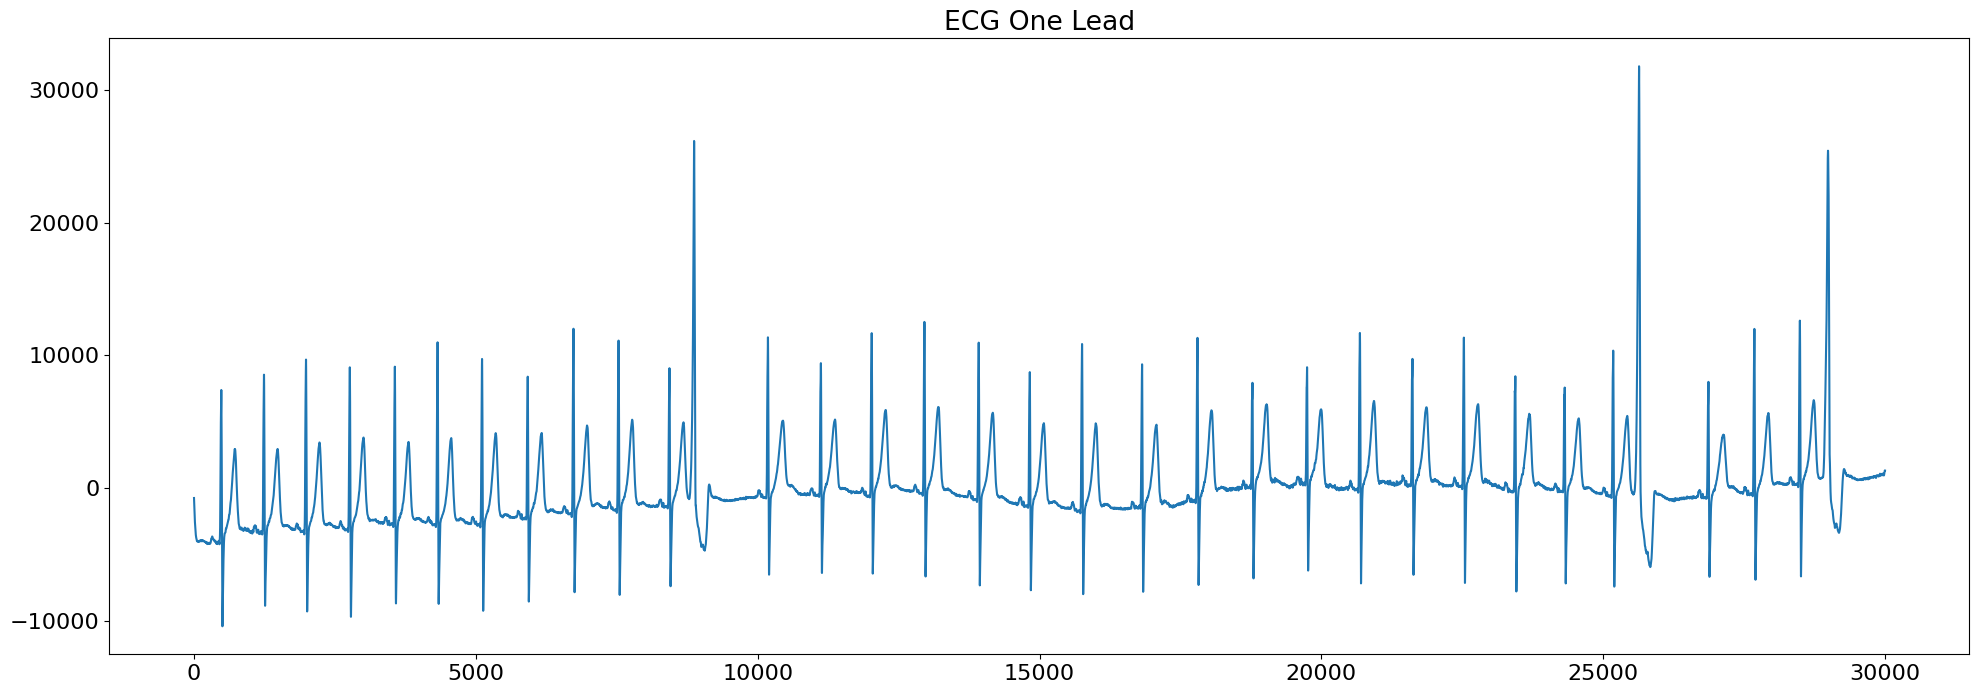

In [45]:
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead[:30000])
plt.title("ECG One Lead")
plt.show()

# Plantilla de Filtro con pytc2

Se hace uso del modulo de python propuesto por la cátedra: [pytc2](https://pytc2.readthedocs.io/en/latest/)

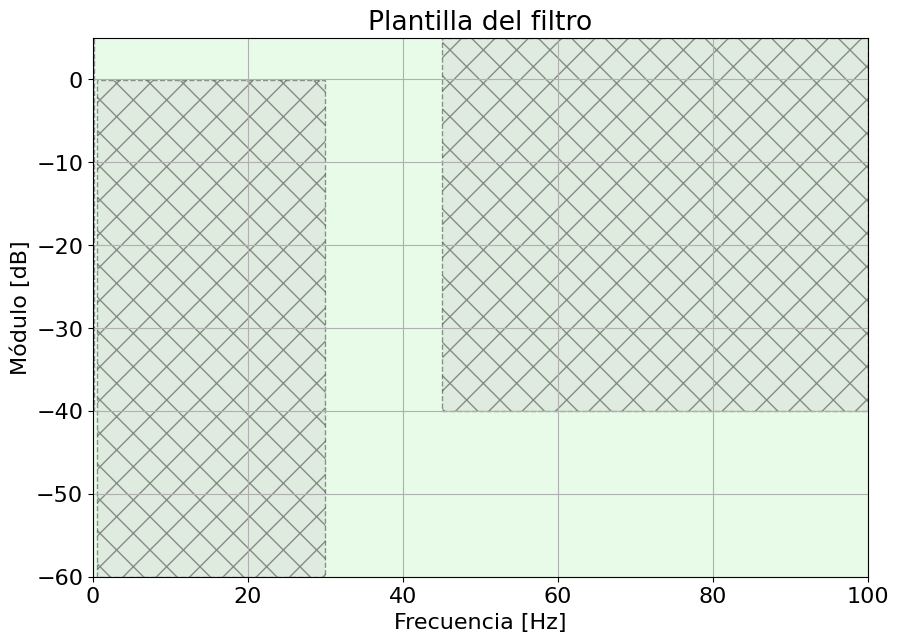

In [46]:
# Plantilla

# filter design
ripple = 0.1  # dB
atenuacion = 40  # dB

ws1 = 0.1  # Hz
wp1 = 0.5  # Hz
wp2 = 30.0  # Hz
ws2 = 45.0  # Hz

frecs = np.array([0.0, ws1, wp1, wp2, ws2, nyq_frec]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10 ** (gains / 20)

plt.title("Plantilla del filtro")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Módulo [dB]")
plt.grid()
plt.axis([0, 100, -60, 5])

plot_plantilla(
    filter_type="bandpass",
    fpass=frecs[[2, 3]] * nyq_frec,
    ripple=ripple,
    fstop=frecs[[1, 4]] * nyq_frec,
    attenuation=atenuacion,
    fs=fs,
)

# Se diseña el filtro FIR

Se utiliza `firwin2` con la window "cosine" y `firls` para mostrar otro método, y para ello, hay que realizar 2 secciones. 

Con `firls` se diseña un filtro pasabajo y otro pasaaltos debido a que el método utilizado para calcular el filtro resulta con irregularidades debido a la diferencia entre la banda superior e inferior, o dicho de otras palabras, el filtro resulta más exigente en bajas frecuencias que en altas frecuencias. En altas frecuencias tiene más margen.

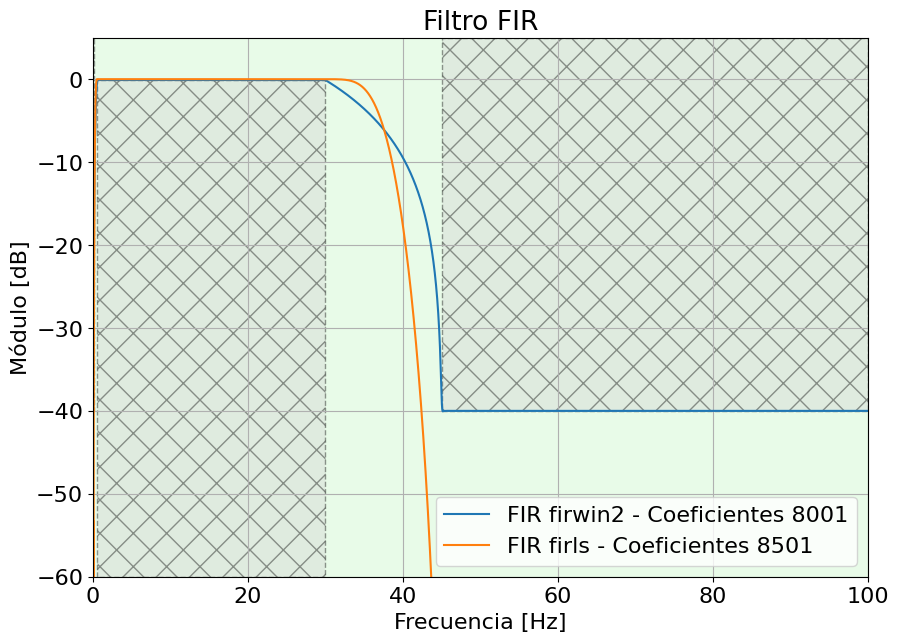

In [76]:
taps = 8001

# El "filtro" es el numerador de la transferencia. Por ser un FIR, el denominador es 1.
num_firwin = sig.firwin2(taps, frecs, gains, window="cosine")
den = 1.0

num_firls_lp = sig.firls(
    numtaps=501,
    bands=[[0,wp2], [ws2, nyq_frec]],
    desired=[[1,1],[0,0]],
    fs=fs,
)

num_firls_hp = sig.firls(
    numtaps=taps,
    bands=[[0,ws1], [wp1,nyq_frec]],
    desired=[[0,0],[1,1]],
    fs=fs,
)

num_firls = sig.convolve(num_firls_hp, num_firls_lp)

w, hh_win = sig.freqz(num_firwin, den, worN=100000)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(
    w,
    20 * np.log10(abs(hh_win)),
    label="FIR firwin2 - Coeficientes {:d}".format(num_firwin.shape[0]),
)

w, hh_win = sig.freqz(num_firls, den, worN=100000)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(
    w,
    20 * np.log10(abs(hh_win)),
    label="FIR firls - Coeficientes {:d}".format(num_firls.shape[0]),
)

plt.title("Filtro FIR")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Módulo [dB]")
plt.grid()
plt.axis([0, 100, -60, 5])
plt.legend()

plot_plantilla(
    filter_type="bandpass",
    fpass=frecs[[2, 3]] * nyq_frec,
    ripple=ripple,
    fstop=frecs[[1, 4]] * nyq_frec,
    attenuation=atenuacion,
    fs=fs,
)

# Se diseña el filtro IIR

Utilizando `iirdesign` con el parametro "sos" (second order sections).

Un Second-Order Section es un bloque de filtro que puede representar hasta dos polos y dos ceros en su función de transferencia. Esto permite que un filtro de orden superior se descomponga en múltiples secciones de segundo orden, cada una manejando una parte del comportamiento del filtro total.

Como los filtros de segundo orden son más estables que filtros de orden superior, se usan muchos filtros de segundo orden concatenados para lograr el comportamiento deseado.

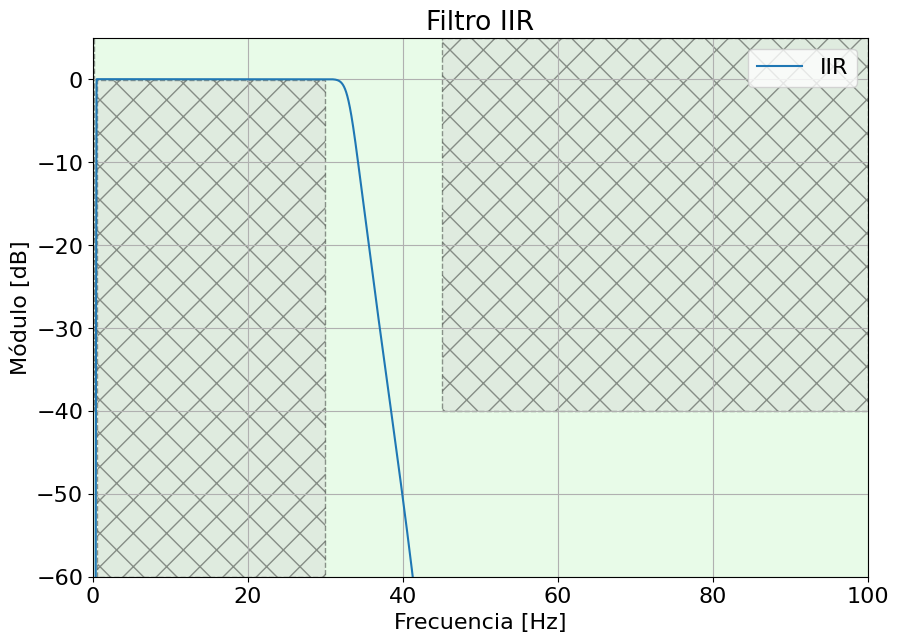

In [71]:
# second-order sections (recommended): 'sos'
sos = sig.iirdesign(
    ws=[ws1, ws2],
    wp=[wp1, wp2],
    gpass=0.0001,
    gstop=100.0,
    fs=fs,
    output="sos",
)

w, h = sig.sosfreqz(sos, worN=100000)
w = w / np.pi * nyq_frec

# Se usa un epsilon para evitar logaritmos de 0
e = 1e-15
plt.plot(
    w,
    20 * np.log10(abs(h)+e),
    label="IIR",
)

plt.title("Filtro IIR")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Módulo [dB]")
plt.grid()
plt.axis([0, 100, -60, 5])
plt.legend()

plot_plantilla(
    filter_type="bandpass",
    fpass=frecs[[2, 3]] * nyq_frec,
    ripple=ripple,
    fstop=frecs[[1, 4]] * nyq_frec,
    attenuation=atenuacion,
    fs=fs,
)

# Se aplican los filtros

Se hace uso de los scripts propuestos en el notebook de la cátedra para graficar y comparar resultados.

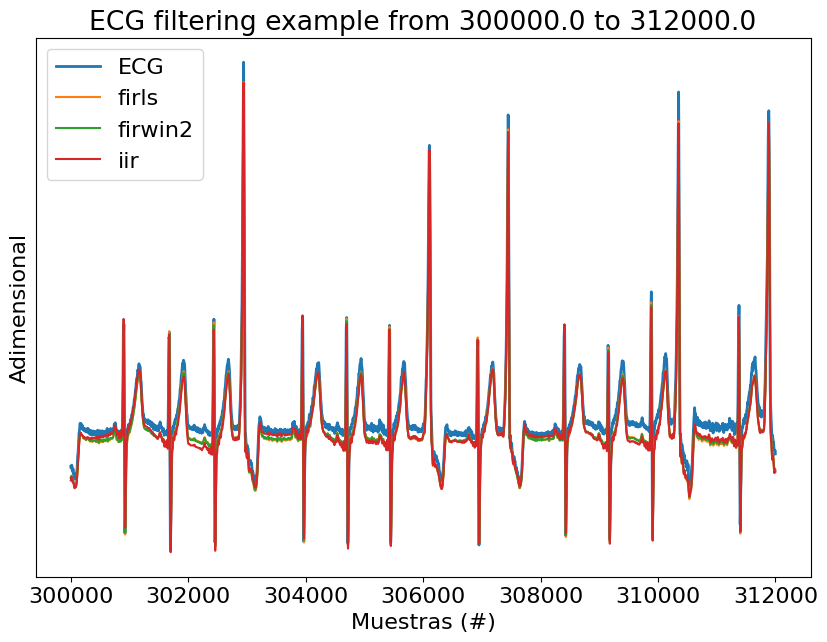

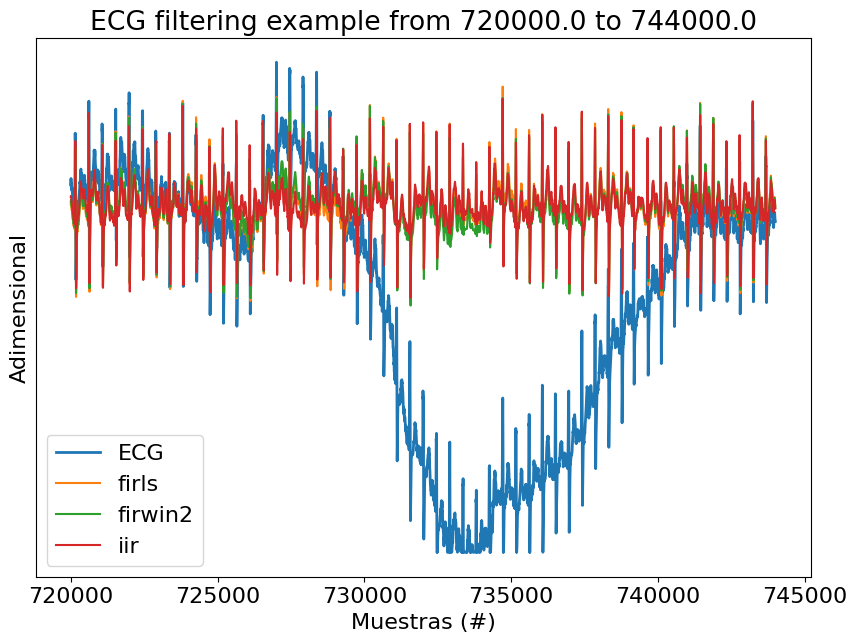

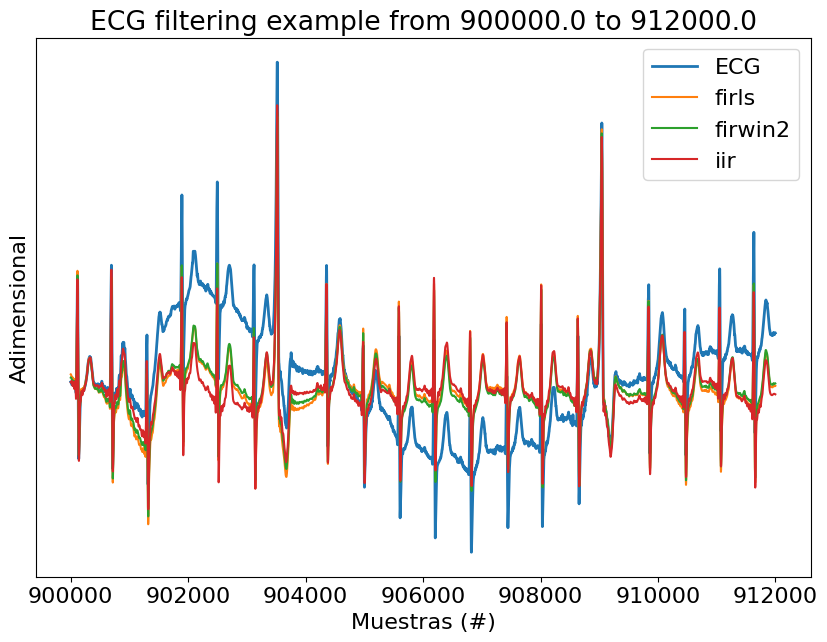

In [74]:
# Se aplica el filtro FIR

ECG_f_win = sig.lfilter(num_firwin, den, ecg_one_lead)
ECG_f_ls = sig.lfilter(num_firls, den, ecg_one_lead)
ECG_iir = sig.sosfiltfilt(sos, ecg_one_lead)

demora = (taps - 1) // 2
demorals = (num_firls.shape[0] - 1) // 2

# Segmentos de interés con ALTA contaminación

regs_interes = (
    np.array([5, 5.2]) * 60 * fs,  # minutos a muestras
    np.array([12, 12.4]) * 60 * fs,  # minutos a muestras
    np.array([15, 15.2]) * 60 * fs,  # minutos a muestras
)

for ii in regs_interes:

    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(
        np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype="uint"
    )

    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi=fig_dpi, facecolor="w", edgecolor="k")
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label="ECG", linewidth=2)
    plt.plot(zoom_region, ECG_f_ls[zoom_region + demorals], label="firls")
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label="firwin2")
    plt.plot(zoom_region, ECG_iir[zoom_region], label="iir")

    plt.title("ECG filtering example from " + str(ii[0]) + " to " + str(ii[1]))
    plt.ylabel("Adimensional")
    plt.xlabel("Muestras (#)")

    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

    plt.show()

El filtro sintetizado con `firls` resulta dificil de sintetizar a comparación del método de ventanas, se debe dividir el problema en dos subproblemas, un filtro pasabajos y un filtro pasaaltos, luego se convoluciona y se obtiene el filtro pasabanda. Y no difiere tanto del filtro sintetizado con `firwin2`.
 
A continuación se procede a evaluar en puntos de interés no tan contaminados.

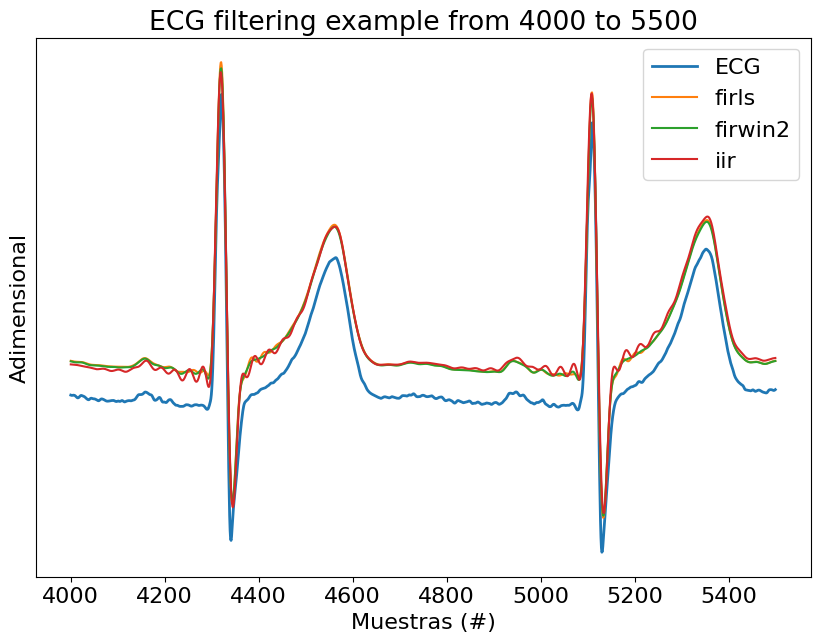

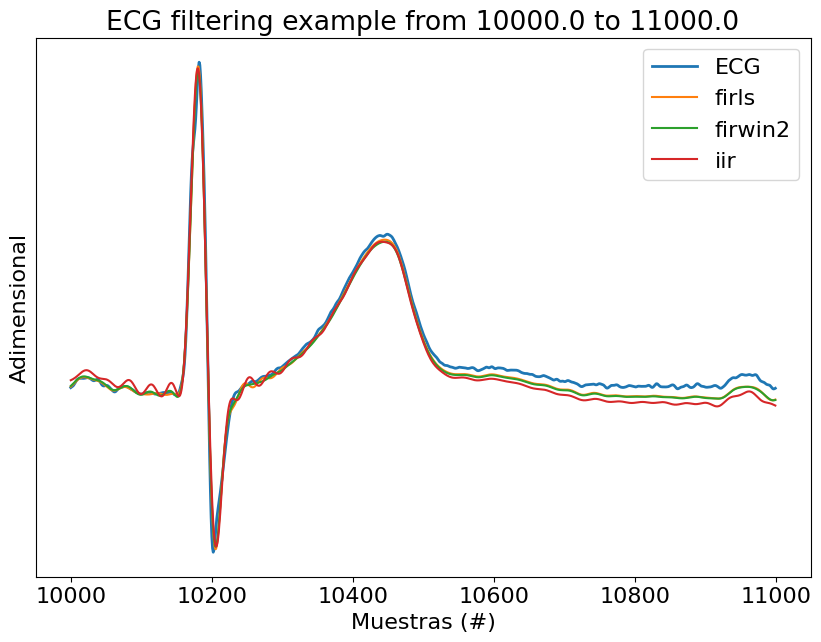

In [75]:
regs_interes = (
    [4000, 5500],  # muestras
    [10e3, 11e3],  # muestras
)

for ii in regs_interes:

    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(
        np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype="uint"
    )

    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi=fig_dpi, facecolor="w", edgecolor="k")
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label="ECG", linewidth=2)
    plt.plot(zoom_region, ECG_f_ls[zoom_region + demorals], label="firls")
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label="firwin2")
    plt.plot(zoom_region, ECG_iir[zoom_region], label="iir")
    
    plt.title("ECG filtering example from " + str(ii[0]) + " to " + str(ii[1]))
    plt.ylabel("Adimensional")
    plt.xlabel("Muestras (#)")

    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

    plt.show()

# Conclusiones

Se aprecia que el filtro `IIR` muestra oscilaciones, además se requiere mucha carga computacional para diseñar un filtro de orden elevado.
En el caso del ECG, las interferencias tienen componentes no lineales o son resultado de interacciones complejas dentro del sistema, un filtro lineal podría no ser suficiente para la eliminación efectiva de la señal de baja frecuencia que contamina la señal. Esto puede dar lugar a artefactos adicionales en la señal filtrada, como oscilaciones no deseadas.

No hay que perder de vista el hecho de que al aplicar un filtro, especialmente si es demasiado agresivo, se puede perder información crítica que es necesaria para un diagnóstico adecuado. Esto puede incluir detalles sobre la dinámica del corazón que son esenciales para interpretar correctamente el ECG.

 En un entorno digital, los filtros pueden ser fácilmente reprogramados para adaptarse a diferentes tipos de señales o condiciones cambiantes sin necesidad de modificar el hardware físico. Esto permite una mayor versatilidad en aplicaciones biomédicas

 En resumen, la efectividad de los filtros digitales en el procesamiento de señales como el ECG depende críticamente de su diseño y configuración, así como del contexto específico en el que se aplican. La capacidad para adaptarse y optimizarse dentro de arquitecturas digitales representa una oportunidad significativa para mejorar la calidad del procesamiento de señales biomédicas.